In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.dates as mdates

# Load the dataset
df_features = pd.read_csv("features.csv")
df_store = pd.read_csv("stores.csv")
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [2]:
#To standardize column names for consistency
df_train.columns = df_train.columns.str.lower().str.replace(' ', '_')
df_store.columns = df_store.columns.str.lower().str.replace(' ', '_')
df_features.columns = df_features.columns.str.lower().str.replace(' ', '_')

In [3]:
df_features.head()

,store,date,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,isholiday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [4]:
df_store.head()

,store,type,size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [5]:
df_train.head()

,store,dept,date,weekly_sales,isholiday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [6]:
df_test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [7]:
train_df = pd.merge(df_train,df_store,on='store',how='left')
train_df.head()

,store,dept,date,weekly_sales,isholiday,type,size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-03-05,21827.90,False,A,151315


In [8]:
# Merge df_features with df_train on 'store' and 'date'
merged_df = pd.merge(df_features, df_train, on=['store', 'date'], how='inner')

# Merge the result with df_stores on 'store' only
final_merged_df = pd.merge(merged_df, df_store, on='store', how='inner')
final_merged_df.head()

,store,date,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,isholiday_x,dept,weekly_sales,isholiday_y,type,size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,1,24924.50,False,A,151315
1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2,50605.27,False,A,151315
2,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,3,13740.12,False,A,151315
3,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,4,39954.04,False,A,151315
4,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,5,32229.38,False,A,151315


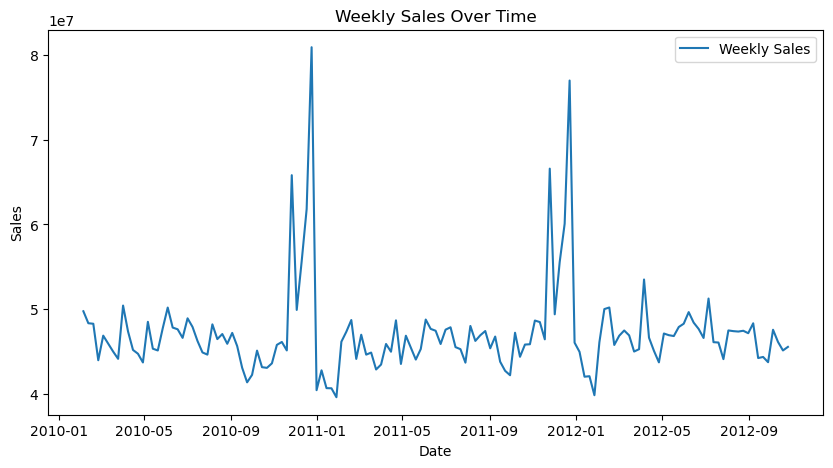

In [9]:
# Plot raw time series

weekly_sales = final_merged_df.groupby('date')['weekly_sales'].sum()
weekly_sales.index = pd.to_datetime(weekly_sales.index)

# Plot raw time series
plt.figure(figsize=(10, 5))
plt.plot(weekly_sales, label="Weekly Sales")
plt.title("Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


### Check for stationarity 

In [10]:
# ADF Test for stationarity
result = adfuller(final_merged_df['weekly_sales'])

print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

if result[1] > 0.05:
    print("Series is Non-Stationary. Differencing is required.")
else:
    print("Series is Stationary. Proceed with ARIMA.")

ADF Statistic: -9.251340872431507
p-value: 1.4893921693365439e-15
Critical Values: {'1%': -3.4303655154786736, '5%': -2.861546857656134, '10%': -2.5667736500803486}
Series is Stationary. Proceed with ARIMA.


In [11]:
# Define the training period
train = weekly_sales.iloc[:-52]  # Use all but the last year for training
test = weekly_sales.iloc[-52:]   # Use the last year for testing

### Fit the ARIMA model

In [12]:
model = ARIMA(train, order=(5,1,0))  # (p,d,q) parameters can be tuned
model_fit = model.fit()

/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


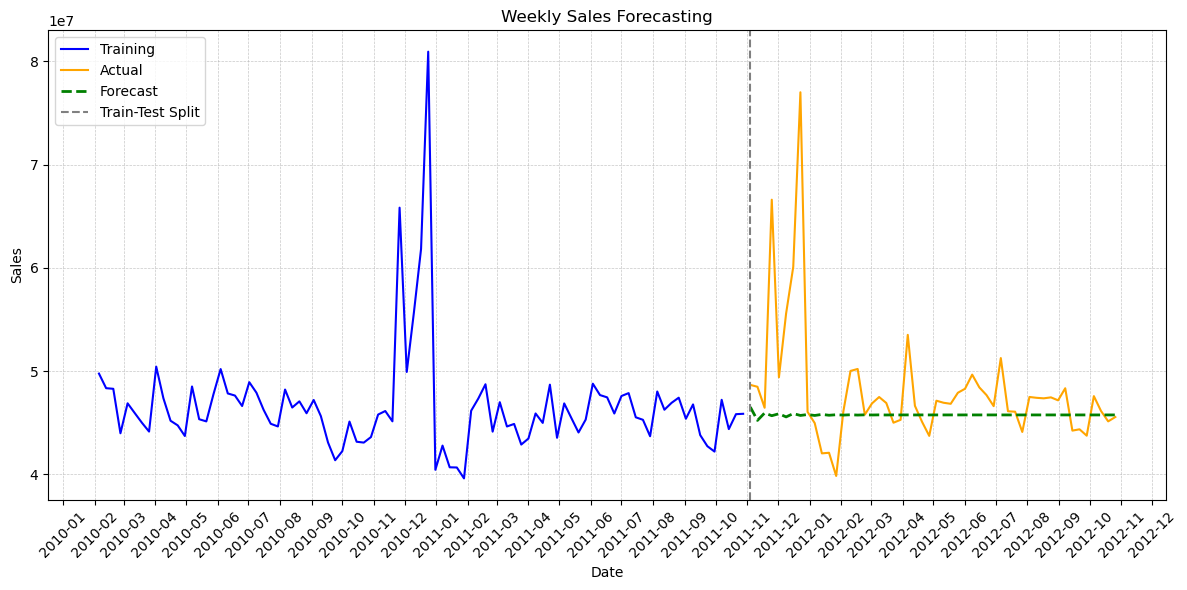

In [13]:
# Forecast for the test period
forecast = model_fit.get_prediction(start=test.index[0], end=test.index[-1])
forecast_values = forecast.predicted_mean

# Plot the forecast against the actual values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training', color='blue')
plt.plot(test.index, test, label='Actual', color='orange')
plt.plot(test.index, forecast_values, label='Forecast', color='green', linestyle='--', linewidth=2)

# Format the x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Show every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as 'Year-Month'
plt.xticks(rotation=45)  # Rotate for readability

# Add a grid and train-test split line
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.axvline(x=test.index[0], color='gray', linestyle='--', label='Train-Test Split')

# Add title and labels
plt.title('Weekly Sales Forecasting')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


### Tuning ARIMA model

In [14]:
final_merged_df['date'] = pd.to_datetime(final_merged_df['date'])

# Aggregate the data by week
weekly_sales = final_merged_df.groupby('date')['weekly_sales'].sum().reset_index()

# Set the date as the index
weekly_sales.set_index('date', inplace=True)

# Define the training period
train = weekly_sales.iloc[:-52]  # Use all but the last year for training
test = weekly_sales.iloc[-52:]   # Use the last year for testing

# Grid search for ARIMA parameters
best_aic = np.inf
best_order = None
best_model = None

# Define a range of p, d, q values to try
p_values = range(0, 6)
d_values = range(0, 2)
q_values = range(0, 6)

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train, order=(p, d, q))
                model_fit = model.fit()
                aic = model_fit.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    best_model = model_fit
            except Exception as e:
                continue

print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")

# Use the best model for predictions
predictions = best_model.forecast(steps=len(test))

# Evaluate the model
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)

print(f"RMSE for best ARIMA model: {rmse}")

/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency 

/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency 

/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency 

/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency 

/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages

Best ARIMA order: (0, 1, 5) with AIC: 3050.934138206959
RMSE for best ARIMA model: 6263405.372220255


/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


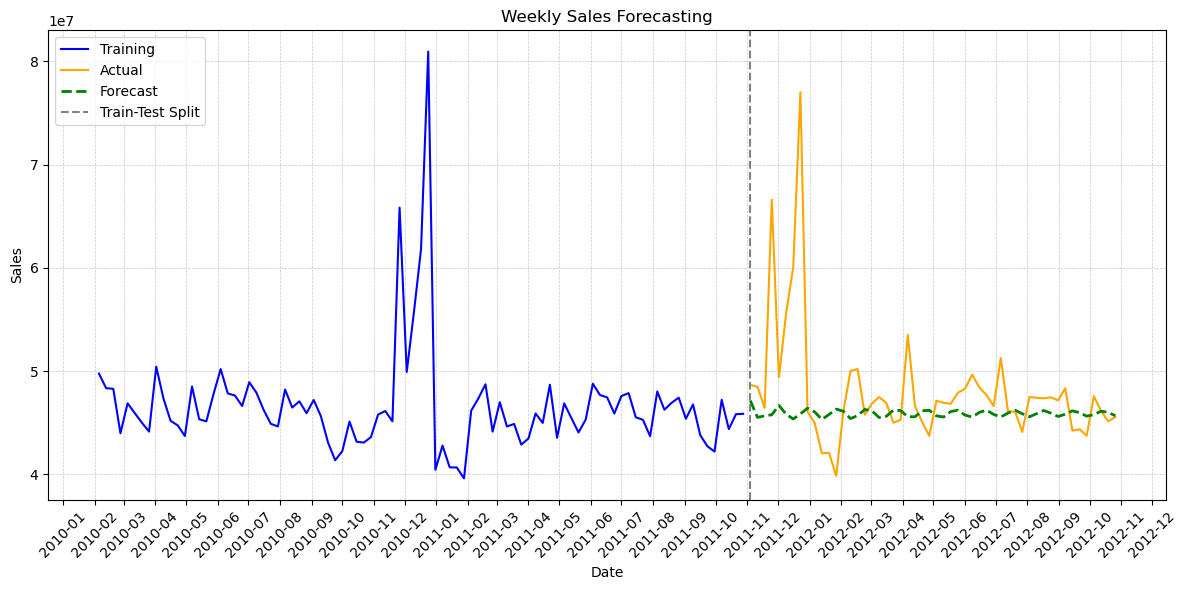

In [15]:
# Forecast for the test period
forecast = model_fit.forecast(steps=len(test))  # Generate the forecast

# Plot the forecast against the actual values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training', color='blue')
plt.plot(test.index, test, label='Actual', color='orange')
plt.plot(test.index, forecast, label='Forecast', color='green', linestyle='--', linewidth=2)

# Format the x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Show every 1 month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as 'Year-Month'
plt.xticks(rotation=45)  # Rotate for readability

# Add a grid and train-test split line
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.axvline(x=test.index[0], color='gray', linestyle='--', label='Train-Test Split')

# Add title and labels
plt.title('Weekly Sales Forecasting')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### FIT SARIMA 

In [16]:
# Grid search for ARIMA/SARIMA parameters
best_aic = np.inf
best_order = None
best_seasonal_order = None
best_model = None

# Define a range of p, d, q values to try
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 2)
D_values = range(0, 2)
Q_values = range(0, 2)
S = 52  # Assuming weekly seasonality

for p in tqdm(p_values):
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        try:
                            model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, S), enforce_stationarity=False, enforce_invertibility=False)
                            model_fit = model.fit(disp=False)
                            aic = model_fit.aic
                            if aic < best_aic:
                                best_aic = aic
                                best_order = (p, d, q)
                                best_seasonal_order = (P, D, Q, S)
                                best_model = model_fit
                        except Exception as e:
                            continue

print(f"Best SARIMA order: {best_order} with seasonal order: {best_seasonal_order} and AIC: {best_aic}")
# Walk-forward validation
predictions = []
for i in range(len(test)):
    train_data = weekly_sales.iloc[:-(52-i)]
    model = SARIMAX(train_data, order=best_order, seasonal_order=best_seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=1)
    predictions.append(forecast.values[0])

# Evaluate the model
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)

print(f"RMSE for best SARIMA model: {rmse}")


  0%|                                                     | 0/3 [00:00<?, ?it/s]/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/

/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python

/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few ob

/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few ob

/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python

/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python

/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few ob

/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 67%|██████████████████████████████               | 2/3 [00:36<00:19, 19.07s/it]/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI w

/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few ob

/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few ob

/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/teeteam/anac

Best SARIMA order: (0, 0, 0) with seasonal order: (0, 1, 1, 52) and AIC: 4.0


/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few

/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python

/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python

/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python

/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/teeteam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/teeteam/anaconda3/lib/python

RMSE for best SARIMA model: 2128341.295087865


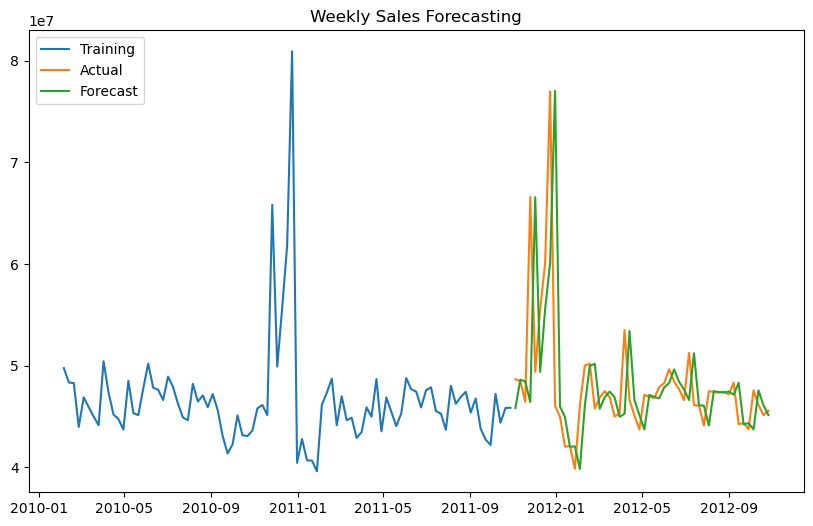

In [17]:
# Forecast for the test period
forecast = model_fit.forecast(steps=len(test))

# Plot the forecast against the actual values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Training')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast')
plt.legend(loc='upper left')
plt.title('Weekly Sales Forecasting')
plt.show()

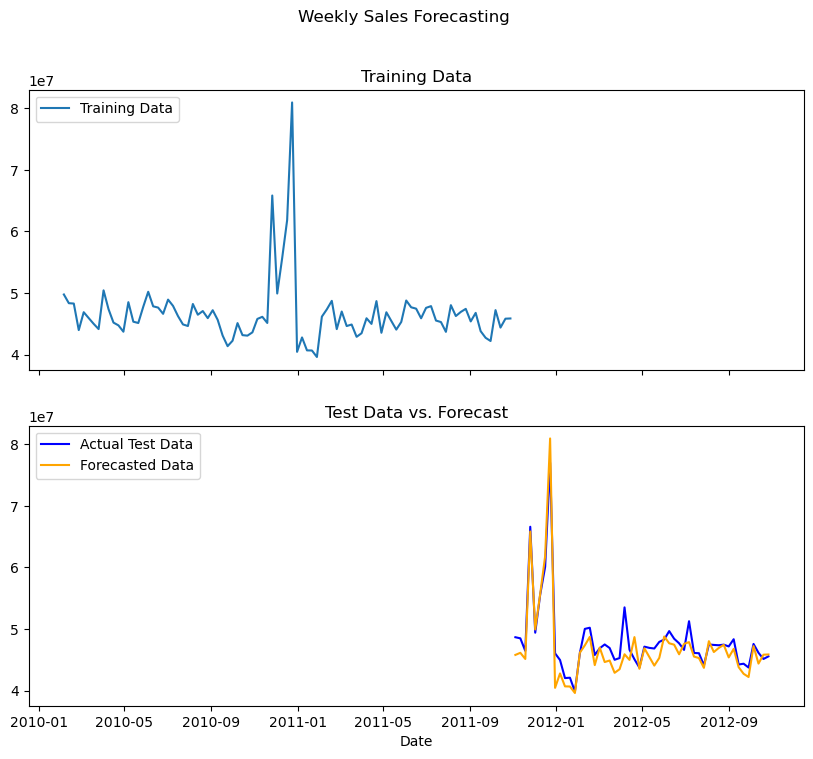

In [18]:
# Forecast for the test period
forecast = best_model.forecast(steps=len(test))

# Plot the training and test data with forecasts in two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Upper subplot for training data
ax1.plot(train.index, train, label='Training Data')
ax1.set_title('Training Data')
ax1.legend(loc='upper left')

# Lower subplot for test data and forecasts
ax2.plot(test.index, test, label='Actual Test Data', color='blue')
ax2.plot(test.index, forecast, label='Forecasted Data', color='orange')
ax2.set_title('Test Data vs. Forecast')
ax2.legend(loc='upper left')

# Set common x-axis label and overall title
fig.suptitle('Weekly Sales Forecasting')
plt.xlabel('Date')
plt.show()

In [19]:
# Calculate MAE
mae = mean_absolute_error(test, predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, predictions))

# Calculate MAPE
mape = np.mean(np.abs((test.values - predictions) / test.values)) * 100

# Calculate Accuracy as a Percentage (1 - MAPE/100)
accuracy_percentage = 100 - mape

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
print(f"Accuracy: {accuracy_percentage}%")

Mean Absolute Error (MAE): 1597388.9843514762
Root Mean Squared Error (RMSE): 2128341.295087865
Mean Absolute Percentage Error (MAPE): 10.139488649095092%
Accuracy: 89.86051135090491%
